# Feature selection
-----
- z-stack Movies were prepared from the merged tilescan images
- We are now ready for feature extraction from the movies


In [1]:
%matplotlib notebook

# Dependencies

import os
import cv2
import merging_functions as mf
import numpy as np
import tracker as tr

from matplotlib import pyplot as plt

from bs4 import BeautifulSoup

In [2]:
# Go through each timepoint and each frame to collect the pixel and their locations that exceeds the threshold
def get_image_sequence(video_folder, exp_name, acq_name, t_str):
    # Run through a single timepoint
    video_path = os.path.join(video_folder, f"{exp_name}_{acq_name}_{t_str}.avi")

    # Video capture object
    vidcap = cv2.VideoCapture(video_path)

    # Frame properties
    frame_count = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))

    img_seq = np.zeros((frame_height, frame_width, frame_count), np.uint8)
    for fix in range(frame_count):
        # Read frmae
        success,frame = vidcap.read()
        # Convert to grayscale
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        img_seq[:,:,fix] = frame_gray
        
    return img_seq


In [3]:
def collect_radial_data(roi_img, Rar_pxl):
    height, width = roi_img.shape
    centerx = np.int32(width/2)
    centery = np.int32(height/2)
    
    central_sum = np.zeros_like(Rar_pxl, dtype=np.double)
    for Rix in range(len(Rar_pxl)):
        radius = Rar_pxl[Rix]
        circle_img = np.zeros((height,width), np.uint8)
        cv2.circle(circle_img,(centerx,centery), radius,1,thickness=-1)
        masked_data = cv2.bitwise_and(roi_img, roi_img, mask=circle_img)

        central_sum[Rix] = masked_data.sum()/circle_img.sum()/255.0
        
    return central_sum

In [22]:
exp_name = "EQ59_Glu_03142021"
acq_name = "TileScan_24-48h_xyzt"

exp_folder = os.path.join("E:", "Tolga", exp_name)
video_folder = os.path.join(exp_folder, "Videos_Marked", f"{exp_name}_{acq_name}")


metadata = mf.collect_metadata(exp_folder, exp_name, acq_name)

## Locate the center and the ROI of the image

<IPython.core.display.Javascript object>


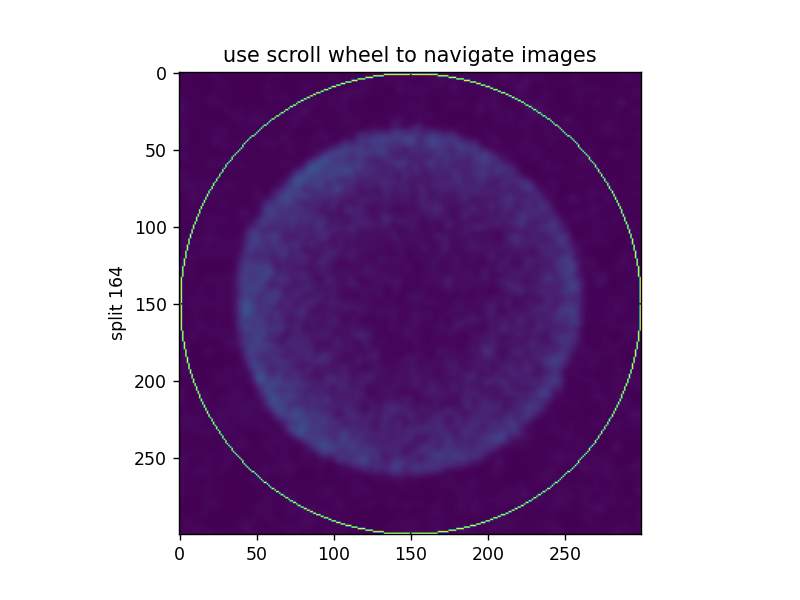

In [25]:
frame_height = 512
frame_width = 512

dr = 1

# ## 48-72h
# centerx = 248
# centery = 245
# radius = 150
# t_str = "t00"

## 24-48h
centerx = 248
centery = 245
radius = 150
t_str = "t23"

# # 12-24h
# centerx = 115
# centery = 200
# radius = 20
# t_str = "t0"

roix = np.array([centerx - radius, centerx + radius], dtype=np.int32)
roiy = np.array([centery - radius, centery + radius], dtype=np.int32)

zsz = metadata["dimensions"]["Z"]["NumberOfElements"]

zar = np.arange(0,zsz)
img_seq = get_image_sequence(video_folder, exp_name, acq_name, t_str)
roi_image = img_seq[roiy[0]:roiy[1], roix[0]:roix[1], 0]
roi_height,roi_width = roi_image.shape
img_seq_maxz = np.zeros((roi_height, roi_width, zsz)) # numpy 3d array image sequence to track max intensity images
Rar_pxl = np.arange(5,roi_width/2, dr, dtype=np.int32)
for zix in range(zsz):
    roi_image = img_seq[:, :, zix]
    blurred_image = cv2.GaussianBlur(roi_image, (15,15), 0).astype(np.uint8)
    cv2.circle(blurred_image, (centerx, centery), radius, (255,255,255), 1)
    img_seq_maxz[:,:,zix] = blurred_image[roiy[0]:roiy[1], roix[0]:roix[1]]
    
# Plot the image sequence in a figure
fig_maxint_img, ax = plt.subplots()
tracker = tr.IndexTracker(ax, img_seq_maxz, "image", 160)#, args_dict)

fig_maxint_img.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

## Calculate the average intensity of the chosen image, and check the plot

<IPython.core.display.Javascript object>


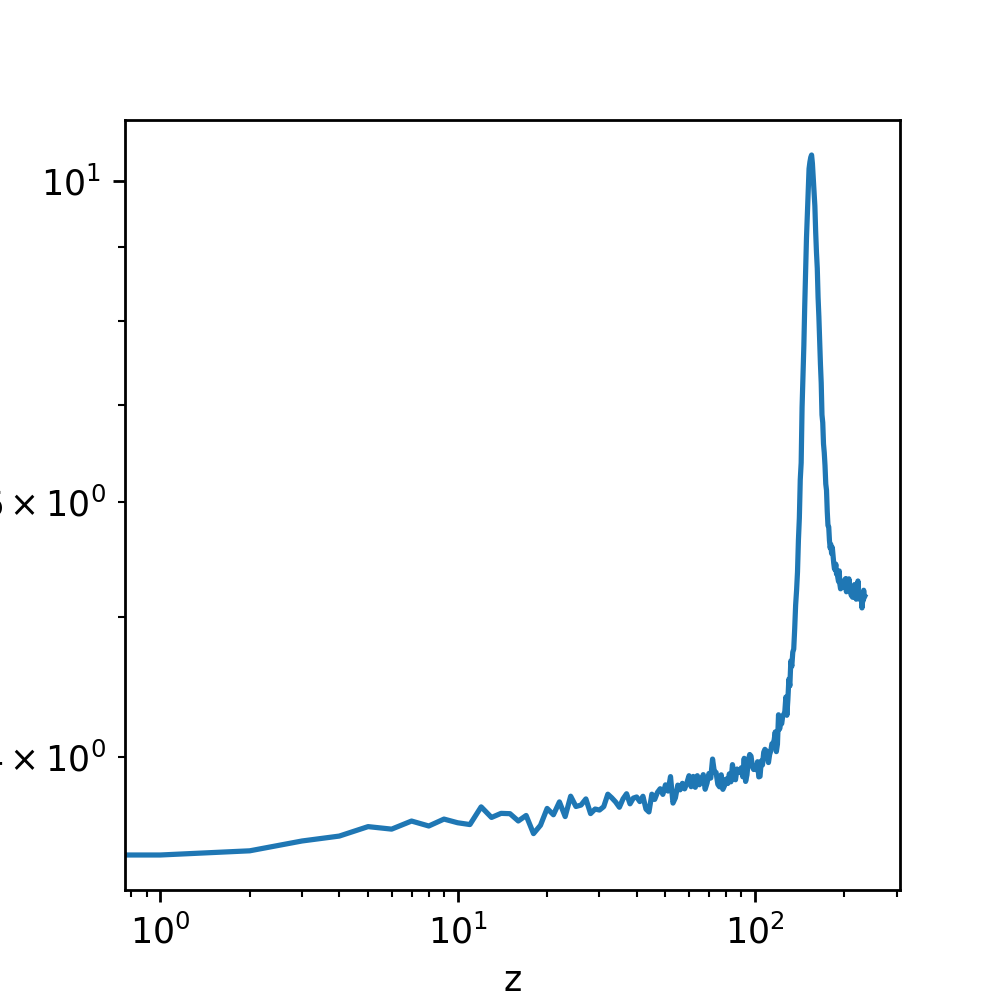

Text(0, 0.5, 'Average pixel brightness')

In [26]:
def window(size):
    return np.ones(size)/float(size)

avg_intensity = np.zeros(zsz)
for zix in range(zsz):
    image = img_seq[:,:,zix]
    # Use blurred_image for nice plots
    avg_intensity[zix] = image.mean()
fig_maxint_img, ax = plt.subplots(figsize=(4,4), dpi=200)
# ax.loglog(zar, np.convolve(avg_intensity, window(10), mode="same"))
ax.loglog(zar, avg_intensity)
# ax.set_ylim(0,1)
ax.set_xlabel("z")
ax.set_ylabel("Average pixel brightness")


## Find the surface z values and record data

In [27]:
tsz = metadata["dimensions"]["T"]["NumberOfElements"]
zvoxel = metadata["dimensions"]["Z"]["Voxel"]
# Find the number of digits
tnum_digit = len(str(tsz))
# sstr for file path
tstr_holder = f"t%0{tnum_digit}d"

zsurf_vals = np.zeros(tsz)
surf_idx = np.zeros(tsz, dtype=np.int32)
for tix in range(tsz):
    print(f"Calculating {tix}/{tsz}", end="\r", flush=True)
    t_str = tstr_holder % (tix)
    img_seq = get_image_sequence(video_folder, exp_name, acq_name, t_str)

    avg_intensity = np.zeros(zsz)
    for zix in range(zsz):
        image = img_seq[:,:,zix]
        # Use blurred_image for nice plots
        avg_intensity[zix] = image.mean()
        
    conv_avg = np.convolve(avg_intensity, window(10), mode="same")   # convolved average intensity of the roi image over z values
    zsurf_vals[tix] = zar[np.argmax(conv_avg)]*zvoxel                # surface z value in um
    surf_idx[tix] = np.argmax(conv_avg)                              # index of surface z value


## Measure radius at the surface

In [46]:
# Test for analysis
xvoxel = metadata["dimensions"]["X"]["Voxel"]

central_avg_seq = np.zeros((2,  len(Rar_pxl), tsz))
for tix in range(tsz):
    print(f"Calculating {tix}/{tsz}", end="\r", flush=True)
    t_str = tstr_holder % (tix)
    img_seq = get_image_sequence(video_folder, exp_name, acq_name, t_str)
    
    surf_img = img_seq[surf_idx[tix]]    # surface image
    blurred_image = cv2.GaussianBlur(surf_img, (15,15), 0).astype(np.uint8)
    roi_image = blurred_image[roiy[0]:roiy[1], roix[0]:roix[1]]

    central_avg_seq[0,:, tix] = Rar_pxl
    central_avg_seq[1,:, tix] = collect_radial_data(blurred_image, Rar_pxl)       # central average intensity vs chosen radius

<IPython.core.display.Javascript object>


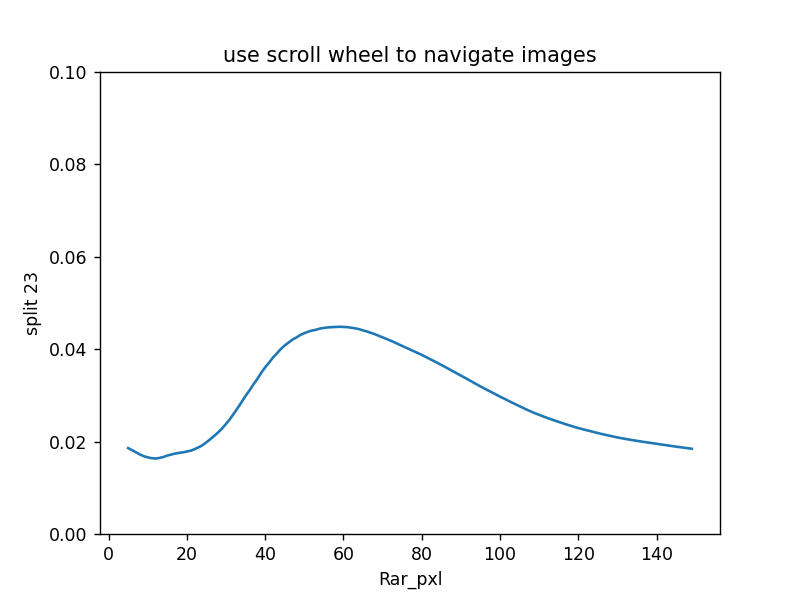

In [47]:
# Plot the image sequence in a figure
fig_maxint_img, ax = plt.subplots()
tracker = tr.IndexTracker(ax, central_avg_seq, "line", 0)#, args_dict)
ax.set_ylim(0,0.1)
ax.set_xlabel("Rar_pxl")
ax.set_ylabel("average intensity")
fig_maxint_img.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

In [ ]:
xvoxel = metadata["dimensions"]["X"]["Voxel"]

rsurf_vals = np.zeros(tsz)
for tix in range(tsz):
    print(f"Calculating {tix}/{tsz}", end="\r", flush=True)
    t_str = tstr_holder % (tix)
    img_seq = get_image_sequence(video_folder, exp_name, acq_name, t_str)
    
    surf_img = img_seq[surf_idx[tix]]    # surface image
    central_avg = collect_radial_data(surf_img, Rar_pxl)       # central average intensity vs chosen radius
    ### Calculate rsurf vals
    
    rsurf_vals[tix] = Rar_pxl[np.argmax(central_avg)]*xvoxel
    
        
    
    

In [29]:
rsurf_vals

array([23.634,  4.545,  5.454,  5.454,  4.545, 10.908, 23.634, 13.635,
        9.09 , 10.908,  4.545,  5.454, 25.452,  4.545, 21.816,  4.545,
       40.905, 35.451, 31.815, 39.087, 40.905, 44.541, 51.813, 55.449])

# Data collection for the height

In [31]:
# 12-24h
rsurf_vals_1 = np.array([0, 0, 0, 0,  4.545, 14.544])
zsurf_vals_1 = np.array([-141.438, -150.01 , -180.012, -210.014, -240.016, -265.732])
height_1 = np.array([np.nan, np.nan, 41, 45, 49, 53])*(-4.286) - zsurf_vals_1
thour_1 = np.arange(0,6*2,2) + 10.23

# 24-48h
rsurf_vals_2 = np.array([23.634,  4.545,  5.454,  5.454,  4.545, 10.908, 23.634, 13.635,
                            9.09 , 10.908,  4.545,  5.454, 25.452,  4.545, 21.816,  4.545,
                           40.905, 35.451, 31.815, 39.087, 40.905, 44.541, 51.813, 55.449])
zsurf_vals_2 = np.array([-400., -408., -420., -428., -440., -448., -456., -468., -476.,
                           -488., -496., -504., -516., -524., -532., -544., -552., -564.,
                           -572., -580., -592., -600., -612., -620.])
height_2 = np.array([80, 84, 85, 89, 92, 95, 97,  99, 102, 104, 106, 109, 111, 114, 115, 
                     117, 119, 122, 125, 126, 128, 131, 133, 135])*(-4) - zsurf_vals_2
thour_2 = np.arange(0,24,1) + 23.73

#48-72h
zsurf_vals_3 = np.array([-440., -452., -464., -472., -484., -492., -500., -512., -524.,
                           -536., -548., -556., -568., -580., -588., -600., -608., -620.,
                           -628., -640., -648., -660., -668., -676.])
# height_2 = np.array([])*(-4) - zsurf_vals_3

<IPython.core.display.Javascript object>


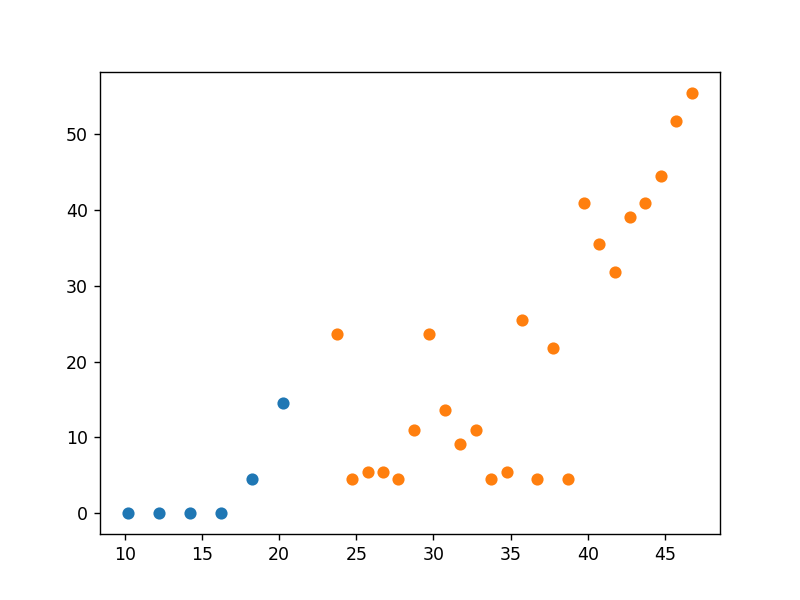

In [32]:
fig,ax = plt.subplots()
ax.plot(thour_1, rsurf_vals_1, 'o', thour_2, rsurf_vals_2, 'o')

# ax.set_xlim(0,60)
# ax.set_ylim(0,150)

In [ ]:
tilescan_folder = os.path.join(exp_folder, "TileScan")
acq_folder = os.path.join(tilescan_folder, f"{exp_name}_{acq_name}")
metadata_folder = os.path.join(tilescan_folder, "MetaData")
xml_path = os.path.join(metadata_folder, f"{exp_name}_{acq_name}_Properties.xml")

# Read xml and prepare for the soup
with open(xml_path) as fp:
    soup = BeautifulSoup(fp, "xml")

In [ ]:
soup

In [ ]:
import datetime

datetime_str = soup.find("StartTime").text
datetime_str

In [ ]:
# date_time_str = '2018-06-29 08:15:27.243860'
date_time_obj = datetime.datetime.strptime(datetime_str, '%m/%d/%Y %I:%M:%S %p.%f')

print('Date:', date_time_obj.date())
print('Time:', date_time_obj.time())
print('Date-time:', date_time_obj)
init_time = date_time_obj.timestamp()

In [ ]:
plate_date_time = datetime.datetime(2021, 3, 14, 23)
diff_time = init_time - plate_date_time.timestamp()

In [ ]:
diff_time/60/60

In [ ]:
metadata["dimensions"]["Z"]["Voxel"]